In [3]:
from sigvisa.models.spatial_regression.local_regression import LocalGPs, BCM, MultiGPLVM
from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample, dgaussian
import scipy.stats
import scipy.optimize

In [4]:

def plot_std(x, y, stds):
    x = x.flatten()
    y = y.flatten()
    stds = stds.flatten()
    plot(x, y, color='blue')
    fill_between(x, y, y+2*stds, facecolor='blue', alpha=0.2)
    fill_between(x, y, y-2*stds, facecolor='blue', alpha=0.2)



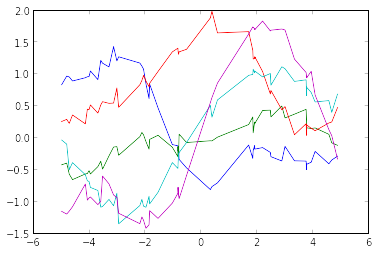

In [5]:
# sample data from the prior
np.random.seed(1)
X = np.asarray(sorted(np.random.rand(50)*10-5)).reshape((-1,1))


cov = GPCov(wfn_params=[1.0], dfn_params=[2.5,], dfn_str="euclidean", wfn_str="se")
noise_var = 0.01
#true_theta = [1.0, 0.5]
KK = mcov(X, cov, noise_var) #cov_matrix(X, X, true_theta) + np.eye(X.shape[0])*noise_var

y = scipy.stats.multivariate_normal(mean=np.zeros((X.shape[0],)), cov=KK).rvs(5)
YY = np.dot(y.T, y)
#y = np.array([prior_sample(X, cov, noise_var) for i in range(5)])

for i in range(y.shape[0]):
    plot(X, y[i,:])


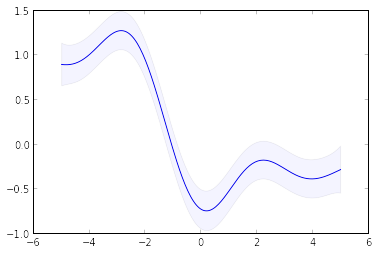

In [6]:
gp = GP(X=X, y=y[0,:], noise_var=noise_var, cov_main=cov, compute_ll=True, sort_events=False, compute_grad=True, sparse_invert=False)
xpred = np.linspace(-5, 5, 200).reshape((-1, 1))
ypred = gp.predict(xpred)
stds = np.sqrt(gp.variance(xpred, include_obs=True))
plot_std(xpred, ypred, stds)


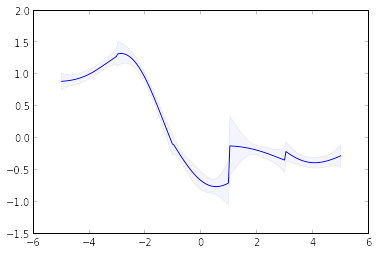

In [7]:
def vec(scalar):
    return np.array((scalar,), dtype=np.float)

centers = [vec(-4), vec(-2), vec(0), vec(2), vec(4)]
#centers = [vec(-3), vec(0), vec(3)]
n_blocks = len(centers)
block_covs = []
lgps = LocalGPs(block_centers=centers, cov_block_params = [(noise_var, 1.0, 2.5)]*n_blocks, X=X, y=y[0,:])

ypred = lgps.predict(xpred)
stds = np.sqrt(np.diag(lgps.covariance(xpred)))
plot_std(xpred, ypred, stds)


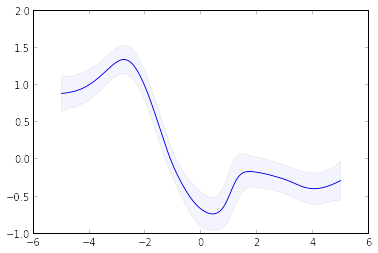

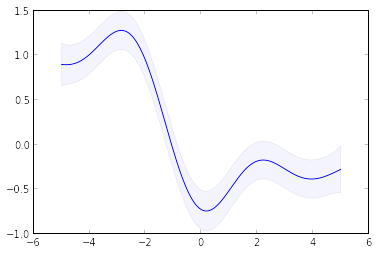

In [8]:
bcm = BCM(test_cov=cov, block_centers=centers, cov_block_params = [(noise_var, 1.0, 2.5)]*n_blocks, X=X, y=y[0,:])
means, vs = bcm.predict_dist(xpred, diag=True)
stds = np.sqrt(vs)    
plot_std(xpred, np.array(means), stds)

figure()
m, c = bcm.predict_dist(xpred, noise_var=noise_var)
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)

# test case for llgrad derivatives
llgrad = bcm.llgrad_X()
print llgrad

def ll(xx):
    bcm2 = bcm.update_X(xx, np.concatenate(bcm.cov_block_params))
    ll, g = bcm2.llgrad_hparam()
    return ll

x0 = bcm.flat_X()
llgrad_f = scipy.optimize.approx_fprime(x0, ll, 1e-6)
print llgrad_f

In [14]:
print gp.log_likelihood()
print lgps.likelihood()
print bcm.likelihood()

-6.34942434772
-7.57105763791
-6.3494219103


In [105]:
print lgps.likelihood_grad()
print gp.ll_grad

[-144.04454662   -0.72175804    0.53734478  -68.31846794   -1.21920903
    0.70273975   79.89463773   -0.43840339    0.30040665 -138.8126086
    3.07697453    0.1580597    30.48163356    4.0997662    -2.03530591]
[-461.68210488    1.92396234    1.85179607]


  status: 0
 success: True
    nfev: 29
     fun: -27.859519591230296
       x: array([ 0.00759487,  2.70325955,  3.06611218])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -1.69928776e-03,  -7.68790155e-06,   3.14276244e-05])
     nit: 18


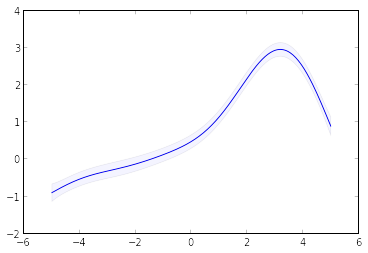

In [106]:
# optimize GP params:
def buildgp(params):
    noise_var = params[0]
    cov = GPCov(wfn_params=params[1:2], dfn_params=params[2:], dfn_str="euclidean", wfn_str="se")
    gp = GP(X=X, y=y[0,:], noise_var=noise_var, cov_main=cov, compute_ll=True, sort_events=False, compute_grad=True)
    return gp

def gp_llgrad(params):
    gp = buildgp(params)
    return -gp.ll, -gp.ll_grad

np.random.seed(0)
x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(gp_llgrad, x0, jac=True, bounds=bounds)
print r

gp = buildgp(r.x)
ypred = gp.predict(xpred)
stds = np.sqrt(gp.variance(xpred, include_obs=True))
plot_std(xpred, ypred, stds)


  status: 0
 success: True
    nfev: 35
     fun: -12.618450735056989
       x: array([ 0.00870678,  2.13322996,  2.97556423])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -4.37407066e-04,  -6.70195854e-09,  -7.02512694e-07])
     nit: 25


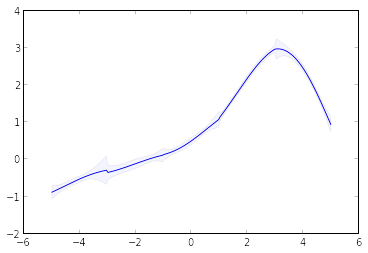

In [107]:
# optimize LGP params:
def build_lgp(params):
    lgps = LocalGPs(block_centers=centers, cov_block_params = [params], X=X, y=y[0,:])
    return lgps

def lgp_llgrad(params):
    lgps = build_lgp(params)
    ll = lgps.likelihood()
    llgrad = lgps.likelihood_grad()
    return -ll, -llgrad

np.random.seed(0)
x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
rl = scipy.optimize.minimize(lgp_llgrad, x0, jac=True, bounds=bounds)
print rl

lgps = build_lgp(rl.x)
ypred = lgps.predict(xpred)
stds = np.sqrt(np.diag(lgps.covariance(xpred)))
plot_std(xpred, ypred, stds)


  status: 2
 success: False
    nfev: 76
     fun: -36.35856732998451
       x: array([  7.27500000e-03,   1.00000000e+02,   5.51980494e+00])
 message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     jac: array([ -1.83591411e-02,  -2.23750215e-02,  -1.05348955e-05])
     nit: 28


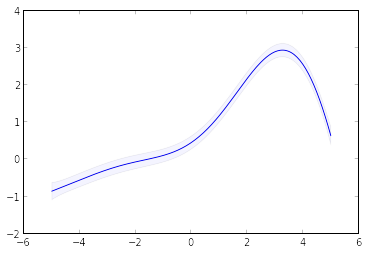

In [111]:
# optimize BCM params:
def build_bcm(params):
    ccov = GPCov(wfn_params=params[1:2], dfn_params=params[2:], dfn_str="euclidean", wfn_str="se")
    bcm1 = BCM(test_cov=ccov, block_centers=centers, cov_block_params = [params], X=X, y=y[0,:])
    return bcm1

def bcm_llgrad(params):
    bcm2 = build_bcm(params)
    ll, llgrad = bcm2.llgrad_hparam()
    return -ll, -llgrad

def bcm_ll(params):
    bcm2 = build_bcm(params)
    return -bcm2.likelihood()


np.random.seed(0)
x0 = np.array((0.01, 1.0, 3.0)) #np.random.rand(3)
bounds = [(0.001, 1), (0.01, 100), (0.01, 10)]

#ll1, llgrad = bcm_llgrad(x0)
#llgrad2 = scipy.optimize.approx_fprime(x0, bcm_ll, 1e-6)
#print llgrad
#print llgrad2


r = scipy.optimize.minimize(bcm_llgrad, x0, jac=True, bounds=bounds)
print r

# TODO: something is wrong with BCM gradients?
bcm3 = build_bcm(r.x)
m, c = bcm3.predict_dist(xpred, noise_var=r.x[0])
stds = np.sqrt(np.diag(c)) 
plot_std(xpred, np.array(m), stds)


In [89]:
print [len(xb) for xb in bcm3.X_blocks]
print [gp.log_likelihood() for gp in bcm3.gps]

print gp_llgrad(r.x)
print bcm_llgrad(r.x)

[8, 6, 12, 16, 8]
[2.4877228856232811, -0.51592428054299422, 1.9431524967904217, 6.5608345022921348, -1.5009831196112398]
(-26.160225213245994, array([ -1.98871665e+02,  -1.33453547e-02,   3.49682804e+00]))
(-32.469406250587518, array([ -3.27127401e-04,  -1.23842344e-01,  -7.97296602e-07]))


In [113]:
def bcmll(sv, ls):
    ll = -bcm_llgrad(np.array((0.01, sv, ls)))[0]
    return ll

def gpll(sv, ls):
    ll = -gp_llgrad(np.array((0.01, sv, ls)))[0]
    return ll

xs = np.linspace(0.1, 20, 30)

bcmlls = np.array([[bcmll(xx, yy) for xx in xs] for yy in xs])
gplls = np.array([[gpll(xx, yy) for xx in xs] for yy in xs])

#plot(xs, bcmlls)
#plot(xs, gplls)



[[ -3.50674360e+02  -7.83091972e+01  -6.91032388e+01  -6.92112496e+01
   -7.10639253e+01  -7.33018015e+01  -7.55614406e+01  -7.77315464e+01
   -7.97802685e+01  -8.17036693e+01  -8.35078595e+01  -8.52022218e+01
   -8.67967258e+01  -8.83008745e+01  -8.97233299e+01  -9.10718294e+01
   -9.23532215e+01  -9.35735476e+01  -9.47381346e+01  -9.58516867e+01
   -9.69183674e+01  -9.79418723e+01  -9.89254920e+01  -9.98721660e+01
   -1.00784529e+02  -1.01664949e+02  -1.02515563e+02  -1.03338302e+02
   -1.04134921e+02  -1.04907013e+02]
 [ -5.55608740e+01   4.07956153e-01  -6.49878110e-01  -2.66293209e+00
   -4.54656410e+00  -6.21593894e+00  -7.69382196e+00  -9.01302874e+00
   -1.02018359e+01  -1.12826731e+01  -1.22730856e+01  -1.31868666e+01
   -1.40349779e+01  -1.48262393e+01  -1.55678346e+01  -1.62656832e+01
   -1.69247151e+01  -1.75490765e+01  -1.81422858e+01  -1.87073534e+01
   -1.92468738e+01  -1.97630988e+01  -2.02579948e+01  -2.07332889e+01
   -2.11905062e+01  -2.16309999e+01  -2.20559762e+01 

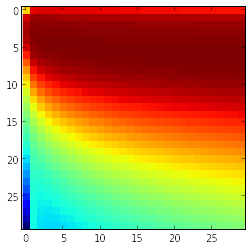

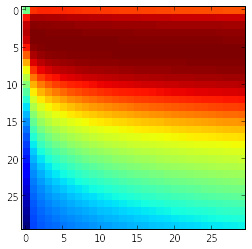

In [114]:
imshow(bcmlls, interpolation="none")
figure()
imshow(gplls, interpolation="none")

print bcmlls

In [39]:
# pseudooptimize BCM params:
def bcm_pseudo_llgrad(params):
    bcm = build_bcm(params)
    ll, llgrad = bcm.cycle_pseudoll()
    return -ll, -llgrad

def grad_step(f, x, alpha):
    ll, llgrad = f(x)
    delta = llgrad*alpha
    x += delta
    return x, delta

def grad_ascent(f, x0, thresh=0.1):
    step = 1
    delta = np.ones(x0.shape)
    x = x0
    while np.linalg.norm(delta) > thresh:            
        alpha = 1.0/step
        x, delta = grad_step(f, x, alpha)
        step += 1
        if step % 10 == 0:
            print "step %d delta %.3f" % (step, delta)
    return x
    
x0 = np.random.rand(3)
print x0
#rx = grad_ascent(bcm_pseudo_llgrad, x0)

bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(bcm_pseudo_llgrad, x0, jac=True, bounds=bounds)


[ 0.54488318  0.4236548   0.64589411]


AttributeError: 'BCM' object has no attribute 'llgrad'

# GPLVM recovery of inputs

 MAD error at initialization 0.423773127393


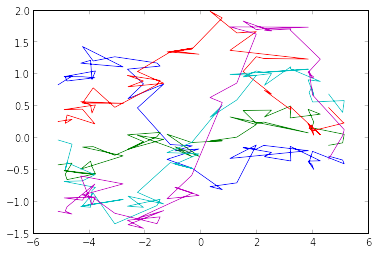

In [30]:
X_obs = X + (np.random.randn(len(X))*.5).reshape((-1, 1))

def x_prior(xx):
    ll = np.sum([scipy.stats.norm(X_obs[i], scale=0.5).logpdf(xx[i]) for i in range(len(xx))])
    lderiv = np.array([-(xx[i]-X_obs[i])/(0.5**2) for i in range(len(xx))]).flatten()
    return ll, lderiv

#x0 = np.random.randn(50)
#ll, g = x_prior(x0)
#print g
#print scipy.optimize.approx_fprime(x0, lambda x : x_prior(x)[0], 1e-4)

def mean_abs_err(x):
    return np.mean(np.abs(x - X.flatten()))

print "MAD error at initialization", mean_abs_err(X_obs.flatten())


for i in range(y.shape[0]):
    plot(X_obs, y[i,:])
    


## Full GP

   status: 0
  success: True
     njev: 86
     nfev: 86
 hess_inv: array([[ 0.05780872,  0.04795163,  0.03864727, ...,  0.01436449,
         0.01454068,  0.01410231],
       [ 0.04795163,  0.05893261,  0.03889739, ...,  0.01442504,
         0.01458052,  0.01428239],
       [ 0.03864727,  0.03889739,  0.04954427, ...,  0.01423948,
         0.01444456,  0.01375009],
       ..., 
       [ 0.01436449,  0.01442504,  0.01423948, ...,  0.04915485,
         0.04403943,  0.04995966],
       [ 0.01454068,  0.01458052,  0.01444456, ...,  0.04403943,
         0.05041995,  0.05137872],
       [ 0.01410231,  0.01428239,  0.01375009, ...,  0.04995966,
         0.05137872,  0.07130995]])
      fun: -103.93576438222982
        x: array([-5.03850241, -4.99003394, -4.60817323, -4.64225056, -4.32051109,
       -4.26604542, -4.27446472, -4.068954  , -4.12781987, -3.59032789,
       -3.74503716, -3.64829335, -3.34083866, -3.48855018, -3.08706016,
       -2.14318896, -2.05375769, -2.07971258, -1.88556231, -

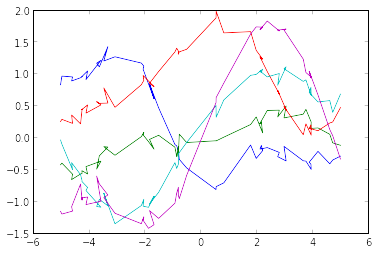

In [31]:

def gpllgrad(xx):
    X = xx.reshape((-1, 1))
    grad = np.zeros(X.shape)
    ll = 0
    for i in range(y.shape[0]):
        gp = GP(X=X, y=y[i,:].flatten(), noise_var=noise_var, 
                cov_main=cov, compute_ll=True, sort_events=False, 
                compute_grad=False, sparse_invert=False)
        xgrad = gp.grad_ll_wrt_X()
        grad += xgrad
        ll += gp.log_likelihood()
    grad = grad.flatten()    
    
    prior_ll, prior_grad = x_prior(xx)
    ll += prior_ll
    grad += prior_grad
    
    return -ll, -grad


#%debug
x0 = X_obs.flatten()
r = scipy.optimize.minimize(gpllgrad, x0, jac=True)
print r

print "MAD error", mean_abs_err(r.x)

for i in range(y.shape[0]):
    plot(r.x, y[i,:])

## Local GP

   status: 2
  success: False
     njev: 51
     nfev: 60
 hess_inv: array([[ 1.00158334, -0.00262315,  0.0103735 , ..., -0.0295761 ,
        -0.04135581, -0.00516576],
       [-0.00262315,  0.96944655,  0.00469651, ..., -0.02489948,
        -0.00926726,  0.05007071],
       [ 0.0103735 ,  0.00469651,  1.00772527, ..., -0.03734983,
        -0.04029075, -0.02478454],
       ..., 
       [-0.0295761 , -0.02489948, -0.03734983, ...,  1.10524354,
         0.16036646,  0.10159003],
       [-0.04135581, -0.00926726, -0.04029075, ...,  0.16036646,
         1.17930276,  0.09029461],
       [-0.00516576,  0.05007071, -0.02478454, ...,  0.10159003,
         0.09029461,  0.94096017]])
      fun: 34.791313148539146
        x: array([-5.46515983, -5.45124522, -4.80669737, -4.85610571, -4.52320571,
       -4.38750057, -4.29775438, -4.2112266 , -4.28974684, -3.48714861,
       -3.7191783 , -3.92733367, -3.17745856, -3.53112516, -3.001203  ,
       -2.71292486, -2.67919711, -2.67217967, -2.42817477, -

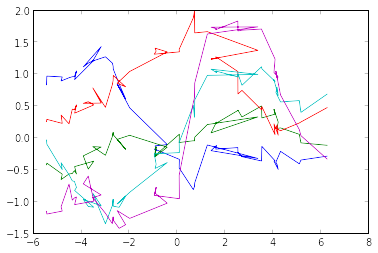

In [32]:
# TODO: gplvm with local GPs

mlgps = MultiGPLVM(X=X, Y=y, cov_block_params = np.array(([noise_var, 1.0, 2.5],)), bcm=False, block_centers=centers)

def lgpllgrad(xx):
    mlgps.update_X(xx)
    ll = mlgps.likelihood()
    grad = mlgps.llgrad_X().flatten()
    #print ll, xx
    prior_ll, prior_grad = x_prior(xx)
    ll += prior_ll
    grad += prior_grad
    
    return -ll, -grad

x0 = X_obs.flatten()
r = scipy.optimize.minimize(lgpllgrad, x0, jac=True)
print r

print "MAD error", mean_abs_err(r.x)

for i in range(y.shape[0]):
    plot(r.x, y[i,:])

   status: 0
  success: True
     njev: 81
     nfev: 81
 hess_inv: array([[ 0.05363962,  0.04487372,  0.0362658 , ...,  0.0145952 ,
         0.01472931,  0.0154342 ],
       [ 0.04487372,  0.05424186,  0.03652812, ...,  0.01402686,
         0.01407446,  0.01461949],
       [ 0.0362658 ,  0.03652812,  0.04801807, ...,  0.01494495,
         0.01495133,  0.01523257],
       ..., 
       [ 0.0145952 ,  0.01402686,  0.01494495, ...,  0.04866224,
         0.04376111,  0.04909266],
       [ 0.01472931,  0.01407446,  0.01495133, ...,  0.04376111,
         0.05077387,  0.05070855],
       [ 0.0154342 ,  0.01461949,  0.01523257, ...,  0.04909266,
         0.05070855,  0.06917159]])
      fun: -112.13895742692907
        x: array([-5.09916259, -5.0566225 , -4.67000238, -4.70675952, -4.35722718,
       -4.31543945, -4.32294947, -4.10609588, -4.1748372 , -3.5716472 ,
       -3.77840902, -3.67641006, -3.3350297 , -3.39437627, -3.16053898,
       -2.19905689, -2.13927836, -2.16158111, -1.87889153, -

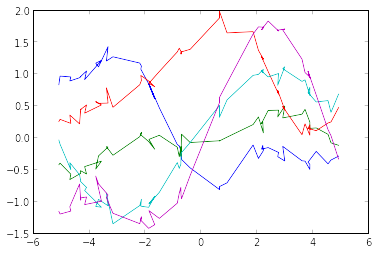

In [33]:
# TODO: gplvm with local GPs

mlgps = MultiGPLVM(X=X, Y=y, cov_block_params = np.array(([noise_var, 1.0, 2.5],)), 
                   bcm=True, block_centers=centers,
                  test_cov=cov)

def bcmllgrad(xx):
    mlgps.update_X(xx)
    ll = mlgps.likelihood()
    grad = mlgps.llgrad_X().flatten()

    
    #print ll, xx
    prior_ll, prior_grad = x_prior(xx)
    ll += prior_ll
    grad += prior_grad
    
    return -ll, -grad

def bcmll(xx):
    mlgps.update_X(xx)
    ll = mlgps.likelihood()

    return -ll

x0 = X_obs.flatten()
r = scipy.optimize.minimize(bcmllgrad, x0, jac=True)
print r

print "MAD error", mean_abs_err(r.x)

for i in range(y.shape[0]):
    plot(r.x, y[i,:])
